
Reproducibility Project Notebook Bonus for CS598 DL4H in Spring 2023<br />

Charles Stolz - cstolz2@illinois.edu<br />
Sean Enright - seanre2@illinois.edu<br />


Group ID: 77<br />
Paper ID: 155<br />

Presentation link: https://www.youtube.com/@DL4H_Group77<br />
Code link: https://github.com/rylandtikes/cs598-project<br />

This notebook reproduces the research in:

[Variationally Regularized Graph-based Representation Learning for Electronic Health Records](https://arxiv.org/abs/1912.03761)


## Table of Contents:
* [Purpose](#Purpose)
* [Summary of Findings](#Summary-of-Findings)
* [Key Results](#Key-Results)
* [MIMIC-III Data](#MIMIC-III-Data)
* [eICU Data](#eICU-Data)
* [Experiments](#Experiments)
* [References](#References)

# Summary of Findings

## Result 1: Encoder-decoder Mortality Prediction with MIMIC-III

Our initial impression is that our model reproduces the results of the authors for MIMIC-III well. The results of the Enc-dec model are reproduced within 0.2%, which also supports the claim that the Enc-dec model performs better than the earlier classical and graph-based methods described above. 

## Result 2: Encoder-decoder Readmission Prediction with eICU

Reproducing the eICU data has proven more challenging. Our training data shows both inconsistency in the performance of the Enc-dec model on readmission prediction, and overall lower performance than described in the paper.

We have included a representative result in our analysis. Our AUPRC value for eICU differs from the authors' by 8%. Furthermore, its performance is worse than all of the competing methods described by the authors.


## Result 3: Variational Regularization Improves Performance Over Encoder-decoder

The performance of the VGNN model supports Claim 3, i.e., that the model improves over the Enc-dec network, but currently, this result only holds for MIMIC-III data. The performance on eICU data has proven to be both inconsistent, so it is sometimes lower than that of Enc-dec, and worse than expected.

With regards to reproducibility, the performance of the VGNN matches the authors' result within 1% for the MIMIC-III prediction task. However, the representative performance of the model on the eICU prediction task within 9%, a difference similar to the result seen in the Enc-dec network on this dataset.



# MIMIC-III Data

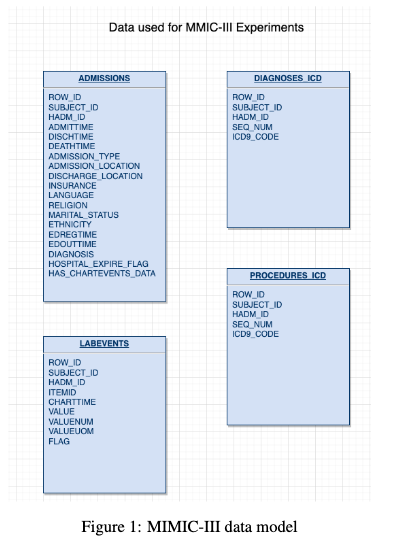




# eICU Data

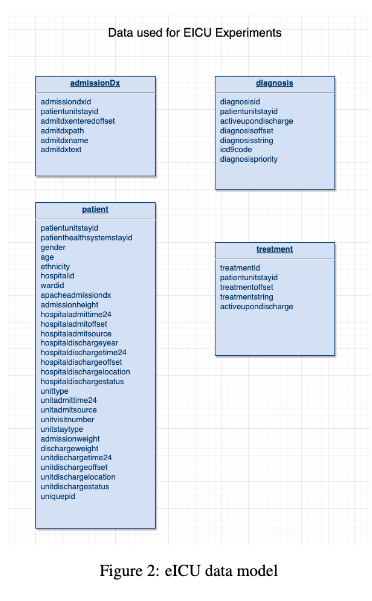

# Key Results

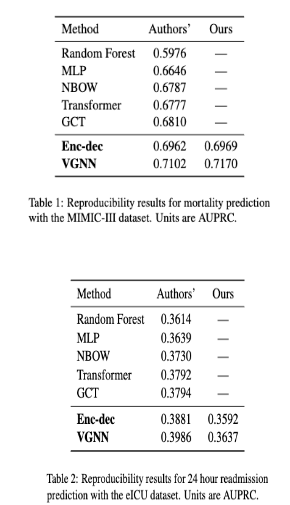

In [ ]:
# Clone the project Git Repo if needed. This will give you the data files which have already been preprocessed.
# This step is only needed if you do not have the repo. If you uploaded the notebook to colab the data files will be needed.

!git clone https://github.com/rylandtikes/cs598-project.git

In [ ]:
# Verify files downloaded
!ls

In [ ]:
# Install Dependencies
%pip install numpy
%pip install pandas
%pip install protobuf
%pip install scikit_learn
%pip install scipy
%pip install tensorflow
%pip install torch
%pip install tqdm
%pip install pyyaml


In [ ]:
import argparse
import torch
import numpy as np
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from collections import Counter
import pickle
from tqdm import tqdm
from datetime import datetime
import os
import logging
import torch.nn.functional as F
from sklearn.metrics import precision_recall_curve, auc
from torch.utils.data import Dataset
import copy
import csv
from pathlib import Path
import yaml
import shutil

In [ ]:
# Verify Nvidia Drivers setup (optional uncomment if desired)
# !nvidia-smi

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

In [ ]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

In [ ]:
# Verify available memory on GPU
print(torch.cuda.memory_summary(device=0, abbreviated=False))

In [ ]:
# model

def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


def clone_params(param, N):
    return nn.ParameterList([copy.deepcopy(param) for _ in range(N)])


class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


class GraphLayer(nn.Module):

    def __init__(self, in_features, hidden_features, out_features, num_of_nodes,
                 num_of_heads, dropout, alpha, concat=True):
        super(GraphLayer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat
        self.num_of_nodes = num_of_nodes
        self.num_of_heads = num_of_heads
        self.W = clones(nn.Linear(in_features, hidden_features), num_of_heads)
        self.a = clone_params(nn.Parameter(torch.rand(size=(1, 2 * hidden_features)), requires_grad=True), num_of_heads)
        self.ffn = nn.Sequential(
            nn.Linear(out_features, out_features),
            nn.ReLU()
        )
        if not concat:
            self.V = nn.Linear(hidden_features, out_features)
        else:
            self.V = nn.Linear(num_of_heads * hidden_features, out_features)
        self.dropout = nn.Dropout(dropout)
        self.leakyrelu = nn.LeakyReLU(self.alpha)
        if concat:
            self.norm = LayerNorm(hidden_features)
        else:
            self.norm = LayerNorm(hidden_features)

    def initialize(self):
        for i in range(len(self.W)):
            nn.init.xavier_normal_(self.W[i].weight.data)
        for i in range(len(self.a)):
            nn.init.xavier_normal_(self.a[i].data)
        if not self.concat:
            nn.init.xavier_normal_(self.V.weight.data)
            nn.init.xavier_normal_(self.out_layer.weight.data)

    def attention(self, linear, a, N, data, edge):
        data = linear(data).unsqueeze(0)
        assert not torch.isnan(data).any()
        # edge: 2*D x E
        h = torch.cat((data[:, edge[0, :], :], data[:, edge[1, :], :]), dim=0)
        data = data.squeeze(0)
        # h: N x out
        assert not torch.isnan(h).any()
        # edge_h: 2*D x E
        edge_h = torch.cat((h[0, :, :], h[1, :, :]), dim=1).transpose(0, 1)
        # edge: 2*D x E
        edge_e = torch.exp(self.leakyrelu(a.mm(edge_h).squeeze()) / np.sqrt(self.hidden_features * self.num_of_heads))
        assert not torch.isnan(edge_e).any()
        # edge_e: E
        edge_e = torch.sparse_coo_tensor(edge.to(device), edge_e.to(device), torch.Size([N, N]))
        e_rowsum = torch.sparse.mm(edge_e, torch.ones(size=(N, 1)).to(device))
        # e_rowsum: N x 1
        row_check = (e_rowsum == 0)
        e_rowsum[row_check] = 1
        zero_idx = row_check.nonzero()[:, 0]
        edge_e = edge_e.add(
            torch.sparse.FloatTensor(zero_idx.repeat(2, 1), torch.ones(len(zero_idx)).to(device), torch.Size([N, N])))
        # edge_e: E
        h_prime = torch.sparse.mm(edge_e, data)
        assert not torch.isnan(h_prime).any()
        # h_prime: N x out
        h_prime.div_(e_rowsum)
        # h_prime: N x out
        assert not torch.isnan(h_prime).any()
        return h_prime

    def forward(self, edge, data=None):
        N = self.num_of_nodes
        if self.concat:
            h_prime = torch.cat([self.attention(l, a, N, data, edge) for l, a in zip(self.W, self.a)], dim=1)
        else:
            h_prime = torch.stack([self.attention(l, a, N, data, edge) for l, a in zip(self.W, self.a)], dim=0).mean(
                dim=0)
        h_prime = self.dropout(h_prime)
        if self.concat:
            return F.elu(self.norm(h_prime))
        else:
            return self.V(F.relu(self.norm(h_prime)))


class VariationalGNN(nn.Module):

    def __init__(self, in_features, out_features, num_of_nodes, n_heads, n_layers,
                 dropout, alpha, variational=True, none_graph_features=0, concat=True):
        super(VariationalGNN, self).__init__()
        self.variational = variational
        self.num_of_nodes = num_of_nodes + 1 - none_graph_features
        self.embed = nn.Embedding(self.num_of_nodes, in_features, padding_idx=0)
        self.in_att = clones(
            GraphLayer(in_features, in_features, in_features, self.num_of_nodes,
                       n_heads, dropout, alpha, concat=True), n_layers)
        self.out_features = out_features
        self.out_att = GraphLayer(in_features, in_features, out_features, self.num_of_nodes,
                                  n_heads, dropout, alpha, concat=False)
        self.n_heads = n_heads
        self.dropout = nn.Dropout(dropout)
        self.parameterize = nn.Linear(out_features, out_features * 2)
        self.out_layer = nn.Sequential(
            nn.Linear(out_features, out_features),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(out_features, 1))
        self.none_graph_features = none_graph_features
        if none_graph_features > 0:
            self.features_ffn = nn.Sequential(
                nn.Linear(none_graph_features, out_features//2),
                nn.ReLU(),
                nn.Dropout(dropout))
            self.out_layer = nn.Sequential(
                nn.Linear(out_features + out_features//2, out_features),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(out_features, 1))
        for i in range(n_layers):
            self.in_att[i].initialize()

    def data_to_edges(self, data):
        length = data.size()[0]
        nonzero = data.nonzero()
        if nonzero.size()[0] == 0:
            return torch.LongTensor([[0], [0]]), torch.LongTensor([[length + 1], [length + 1]])
        if self.training:
            mask = torch.rand(nonzero.size()[0])
            mask = mask > 0.05
            nonzero = nonzero[mask]
            if nonzero.size()[0] == 0:
                return torch.LongTensor([[0], [0]]), torch.LongTensor([[length + 1], [length + 1]])
        nonzero = nonzero.transpose(0, 1) + 1
        lengths = nonzero.size()[1]
        input_edges = torch.cat((nonzero.repeat(1, lengths),
                                 nonzero.repeat(lengths, 1).transpose(0, 1)
                                 .contiguous().view((1, lengths ** 2))), dim=0)

        nonzero = torch.cat((nonzero, torch.LongTensor([[length + 1]]).to(device)), dim=1)
        lengths = nonzero.size()[1]
        output_edges = torch.cat((nonzero.repeat(1, lengths),
                                  nonzero.repeat(lengths, 1).transpose(0, 1)
                                  .contiguous().view((1, lengths ** 2))), dim=0)
        return input_edges.to(device), output_edges.to(device)

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def encoder_decoder(self, data):
        N = self.num_of_nodes
        input_edges, output_edges = self.data_to_edges(data)
        h_prime = self.embed(torch.arange(N).long().to(device))
        for attn in self.in_att:
            h_prime = attn(input_edges, h_prime)
        if self.variational:
            h_prime = self.parameterize(h_prime).view(-1, 2, self.out_features)
            h_prime = self.dropout(h_prime)
            mu = h_prime[:, 0, :]
            logvar = h_prime[:, 1, :]
            h_prime = self.reparameterise(mu, logvar)
            mu = mu[data, :]
            logvar = logvar[data, :]
        h_prime = self.out_att(output_edges, h_prime)
        if self.variational:
            return h_prime[-1], 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2)) / mu.size()[0]
        else:
            return h_prime[-1], torch.tensor(0.0).to(device)

    def forward(self, data):
        # Concate batches
        batch_size = data.size()[0]
        # In eicu data the first feature whether have be admitted before is not included in the graph
        if self.none_graph_features == 0:
            outputs = [self.encoder_decoder(data[i, :]) for i in range(batch_size)]
            return self.out_layer(F.relu(torch.stack([out[0] for out in outputs]))), \
                   torch.sum(torch.stack([out[1] for out in outputs]))
        else:
            outputs = [(data[i, :self.none_graph_features],
                        self.encoder_decoder(data[i, self.none_graph_features:])) for i in range(batch_size)]
            return self.out_layer(F.relu(
                torch.stack([torch.cat((self.features_ffn(torch.FloatTensor([out[0]]).to(device)), out[1][0]))
                             for out in outputs]))), \
                   torch.sum(torch.stack([out[1][1] for out in outputs]), dim=-1)

In [ ]:
# Utils

def train(data, model, optim, criterion, lbd, max_clip_norm=5):
    model.train()
    input = data[:, :-1].to(device)
    label = data[:, -1].float().to(device)
    model.train()
    optim.zero_grad()
    logits, kld = model(input)
    logits = logits.squeeze(-1)
    kld = kld.sum()
    bce = criterion(logits, label)
    loss = bce + lbd * kld
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_clip_norm)
    loss.backward()
    optim.step()
    return loss.item(), kld.item(), bce.item()


def evaluate(model, data_iter, length):
    model.eval()
    y_pred = np.zeros(length)
    y_true = np.zeros(length)
    y_prob = np.zeros(length)
    pointer = 0
    for data in data_iter:
        input = data[:, :-1].to(device)
        label = data[:, -1]
        batch_size = len(label)
        probability, _ = model(input)
        probability = torch.sigmoid(probability.squeeze(-1).detach())
        predicted = probability > 0.5
        y_true[pointer: pointer + batch_size] = label.numpy()
        y_pred[pointer: pointer + batch_size] = predicted.cpu().numpy()
        y_prob[pointer: pointer + batch_size] = probability.cpu().numpy()
        pointer += batch_size
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    return auc(recall, precision), (y_pred, y_prob, y_true)


class EHRData(Dataset):
    def __init__(self, data, cla):
        self.data = data
        self.cla = cla

    def __len__(self):
        return len(self.cla)

    def __getitem__(self, idx):
        return self.data[idx], self.cla[idx]


def collate_fn(data):
    # padding
    data_list = []
    for datum in data:
        data_list.append(np.hstack((datum[0].toarray().ravel(), datum[1])))
    return torch.from_numpy(np.array(data_list)).long()

In [ ]:
# Change values here if using notebook configuration
config_dict = {
    "batch_size": 32,
    "data_path": "./cs598-project/training_results/eicu/out/",
    "dropout": 0.4,
    "embedding_size": 128,
    "eval_freq": 1,
    "kl_scale": 1.0,
    "leaky_relu_alpha": 0.1,
    "lr": 0.0001,
    "num_of_epochs": 1,
    "num_of_heads": 1,
    "num_of_layers": 2,
    "overwrite_save": True,
    "reg": True,
    "result_path": "./",
    "save_model": True,
    "test": True,
    "upsample_factor": 2,
}


# Change to True to use a local configuration file instead of notebook
read_configuration_from_file = False

local_config_file = "./cs598-project/config.yaml"
if read_configuration_from_file:
    with open(local_config_file, mode="rt", encoding="utf-8") as file_handle:
        config_dict = yaml.safe_load(file_handle)


# The values below should not be changed.
################################################################################
batch_size = config_dict["batch_size"]
# input path of processed dataset
data_path = config_dict["data_path"]
dropout = config_dict["dropout"]
embedding_size = config_dict["embedding_size"]
eval_freq = config_dict["eval_freq"]
kl_scale = config_dict["kl_scale"]
leaky_relu_alpha = config_dict["leaky_relu_alpha"]
# learning rate
lr = config_dict["lr"]
num_of_epochs = config_dict["num_of_epochs"]
# number of attention heads
num_of_heads = config_dict["num_of_heads"]
# number of graph layers
num_of_layers = config_dict["num_of_layers"]
overwrite_save = config_dict["overwrite_save"]
# regularization
reg = config_dict["reg"]
# output path of model checkpoints
result_path = config_dict["result_path"]
save_model = config_dict["save_model"]
test = config_dict["test"]
upsample_factor = config_dict["upsample_factor"]
in_features = embedding_size
out_features = embedding_size
################################################################################


gradient_max_norm = 5  # clip gradient to prevent exploding gradient
# Name of the configuration file written to result path
config_file = "config.yaml"


# Load data and upsample training data
train_x, train_y = None, None
if test:
    train_x, train_y = pickle.load(open(data_path + "test_csr.pkl", "rb"))
else:
    train_x, train_y = pickle.load(open(data_path + "train_csr.pkl", "rb"))
    train_upsampling = np.concatenate(
        (
            np.arange(len(train_y)),
            np.repeat(np.where(train_y == 1)[0], upsample_factor - 1),
        )
    )
    train_x = train_x[train_upsampling]
    train_y = train_y[train_upsampling]
val_x, val_y = pickle.load(open(data_path + "validation_csr.pkl", "rb"))

# Configure logging
result_folder = (
    f"reg_{str(reg)}-lr_{lr}-dropout_{dropout}-"
    f"embedding_{in_features}-batch_size_{batch_size}"
)
if test:
    result_folder += "-TEST"
result_root = Path(result_path) / result_folder
result_root.mkdir(exist_ok=True, parents=True)

with open(result_root / config_file, mode="wt", encoding="utf-8") as cf:
    yaml.dump(config_dict, cf)

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    filename=result_root / "train.log",
    format="%(asctime)s %(message)s",
    level=logging.INFO,
)
dataset_name = "test" if test else "training"
logging.info(f"Begin training with {dataset_name} dataset...")
# csv
csv_fields = ["Epoch", "AUPRC", "Loss", "BCE", "KLD"]
csv_log = open(result_root / "train.csv", "wt", encoding="utf-8", buffering=1)
csv_writer = csv.DictWriter(csv_log, delimiter=",", fieldnames=csv_fields)
csv_writer.writeheader()

# initialize models
num_of_nodes = train_x.shape[1] + 1
device_ids = range(torch.cuda.device_count())

# eICU has 1 feature on previous readmission that we didn't include in the graph
model = VariationalGNN(
    in_features,
    out_features,
    num_of_nodes,
    num_of_heads,
    num_of_layers - 1,
    dropout=dropout,
    alpha=leaky_relu_alpha,
    variational=reg,
    none_graph_features=0,
).to(device)
model = nn.DataParallel(model, device_ids=device_ids)
val_loader = DataLoader(
    dataset=EHRData(val_x, val_y),
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=torch.cuda.device_count(),
    shuffle=False,
)
optimizer = optim.Adam(
    [p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=1e-8
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train models
for epoch in range(num_of_epochs):
    train_loader = DataLoader(
        dataset=EHRData(train_x, train_y),
        batch_size=batch_size,
        collate_fn=collate_fn,
        num_workers=torch.cuda.device_count(),
        shuffle=True,
    )
    # BCE Loss is weighted by positive-negative ratio
    counter = Counter(train_y)
    ratio = counter[True] / counter[False]
    pos_weight = torch.ones(1).float().to(device) * ratio
    criterion = nn.BCEWithLogitsLoss(reduction="sum", pos_weight=pos_weight)

    # Configure logging within epoch
    print(f'Epoch: {epoch + 1}, Learning rate: {optimizer.param_groups[0]["lr"]}')
    num_batches = len(train_loader)
    last_batch = num_batches - 1
    update_interval = max(round(num_batches / 20.0, 0), 1)

    # Iterate through batches within epoch
    model.train()
    total_loss = np.zeros(3)
    t = tqdm(iter(train_loader), leave=False, total=last_batch, unit="batch")
    for idx, batch_data in enumerate(t):
        # Train model on batch
        loss, kld, bce = train(
            batch_data, model, optimizer, criterion, kl_scale, gradient_max_norm
        )
        total_loss += np.array([loss, bce, kld])
        if idx > 0:
            curr_loss = total_loss[0] / idx
            curr_bce = total_loss[1] / idx
            curr_kld = total_loss[2] / idx
        # Report training progress within batch via tqdm
        if (idx % update_interval == 0 or idx == last_batch) and idx > 0:
            progress = (
                f"Loss: {curr_loss:.4f}, BCE: {curr_bce:.4f}, KLD: {curr_kld:.4f}"
            )
            t.set_description(progress)
            t.refresh()
        # Save model's state dictionary to file
        if save_model and idx == last_batch and not test:
            param_file = (
                "parameter"
                if overwrite_save
                else f"parameter-epoch_{epoch}-batch_{idx}"
            )
            torch.save(model.state_dict(), result_root / param_file)
        # Evaluate and log training
        if idx == last_batch and (epoch + 1) % eval_freq == 0:
            val_auprc, _ = evaluate(model, val_loader, len(val_y))
            prog = {
                "Epoch": epoch + 1,
                "AUPRC": f"{val_auprc:.4f}",
                "Loss": f"{curr_loss:.4f}",
                "BCE": f"{curr_bce:.4f}",
                "KLD": f"{curr_kld:.4f}",
            }
            csv_writer.writerow(prog)
            eval_log = (
                f'Epoch: {prog["Epoch"]}, AUPRC: {prog["AUPRC"]}, '
                f'Loss: {prog["Loss"]}, BCE: {prog["BCE"]}, KLD: {prog["KLD"]}'
            )
            logging.info(eval_log)
            print(f"AUPRC: {val_auprc:.4f}")
    scheduler.step()
csv_log.close()


In [ ]:
!ls {result_folder}


In [ ]:
!cat {result_folder}/config.yaml


In [ ]:
!cat {result_folder}/train.csv

# References


Edward Choi, Zhen Xu, Yujia Li, Michael W. Dusen-
  berry, Gerardo Flores, Yuan Xue, and Andrew M. Dai.
  2019. Graph convolutional transformer: Learning
  the graphical structure of electronic health records.
  CoRR, abs/1906.04716.

Alistair E.W. Johnson, Tom J. Pollard, Lu Shen, Li-
  wei H. Lehman, Mengling Feng, Mohammad Ghas-
  semi, Benjamin Moody, Peter Szolovits, Leo An-
  thony Celi, Roger G. Mark, and et al. 2016. Mimic-
  iii, a freely accessible critical care database. Scien-
  tific Data, 3(1).

Tom J. Pollard, Alistair E. Johnson, Jesse D. Raffa,
  Leo A. Celi, Roger G. Mark, and Omar Badawi.
  2018. The eicu collaborative research database, a
  freely available multi-center database for critical care
  research. Scientific Data, 5(1).

Charles Stolz and Sean Enright. 2023. Cs598:
  Deep learning for healthcare reproducibility
  project. https://github.com/rylandtikes/
  cs598-project.

Weicheng Zhu and Narges Razavian. 2021. Variation-
  ally regularized graph-based representation learning
  for electronic health records. In Proceedings of
  the Conference on Health, Inference, and Learning,
  CHIL ’21, page 1–13, New York, NY, USA. Associa-
  tion for Computing Machinery.

